# Result on Huxley NetFlow Data


In [1]:
# import packages
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from collections import Counter
from scipy.sparse import coo_matrix
import random
import sklearn.metrics as metrics

#import functions from files
import lanl_function as lanl
import zhu
import gibbs_function as gib
np.random.seed(123)


## Process Data

In [2]:
with open('huxley_2020.pkl', 'rb') as f:
    hux_data = pickle.load(f)

num_key = np.sort(np.array(list(hux_data.keys())))
print(num_key)

['0120' '0121' '0122' '0123' '0124' '0125' '0126' '0127' '0128' '0129'
 '0130' '0131' '0201' '0202']


In [3]:
# re-index 
A = {}
for idx in range(len(num_key)):
    A[idx] = hux_data[num_key[idx]]

# convert into dense format
A_dense = gib.convert_to_dense(A)


In [4]:
# dimension
M, N = A[0].shape
print([M, N])

# threshold T
T=10

# latent dimentsion
d = 7

[164, 250]


## EDA

### Number of links and new links

In [5]:
T=14
link_num_list = []
for t in range(T):
    link_num_list.append(np.sum(A_dense[t]))

A_sum = np.zeros((M, N))
new_link_list = []
for t in range(T):
    previous_total_link = np.sum(A_sum>0)
    A_sum += A_dense[t]
    new_link_list.append(np.sum(A_sum>0) - previous_total_link)

ratio_new = np.array(new_link_list)/np.array(link_num_list)


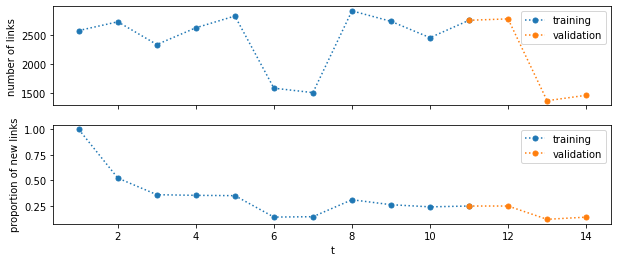

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,4))
ax1.plot( np.linspace(1,11,11) ,link_num_list[:11],linestyle =":", marker="o", markersize=5, label="training")
ax1.plot( np.linspace(11,14,4) ,link_num_list[10:],linestyle =":", marker="o", markersize=5, label="validation")
ax1.set_ylabel("number of links")
ax1.legend()

ax2.plot( np.linspace(1,11,11), ratio_new[:11],linestyle =":", marker="o", markersize=5, label="training")
ax2.plot( np.linspace(11,14,4), ratio_new[10:],linestyle =":", marker="o", markersize=5, label="validation")
ax2.set_ylabel("proportion of new links")
ax2.legend()
plt.xlabel("t")
plt.show()

### Visualisation of network

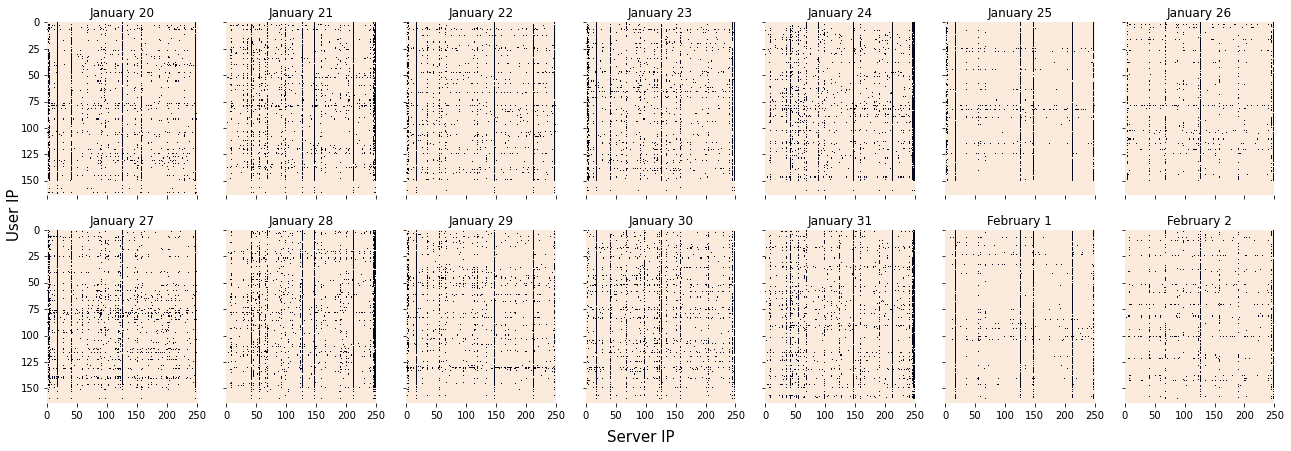

In [8]:
from seaborn import heatmap 
fig, ax = plt.subplots( 2,7,  sharex=True, sharey=True, figsize=(22,7))
x_label_list = np.linspace(0,(N//50)*50,  (N//50)+1)
y_label_list = np.linspace(0, (M//25)*25,  (M//25)+1)
month = ['January',"February"]
for t in range(14):
    month_idx = int(num_key[t])//100
    date_idx = int(num_key[t])%100
    heatmap(np.ones(A_dense[t].shape)-A_dense[t], cbar=False, ax=ax[t//7,t%7])
    ax[t//7,t%7].set_yticks(y_label_list) 
    ax[t//7,t%7].set_yticklabels([int(y_int) for y_int in y_label_list])  
    ax[t//7,t%7].set_xticks(x_label_list) 
    ax[t//7,t%7].set_xticklabels([int(x_int) for x_int in x_label_list], rotation=0)
    ax[t//7,t%7].set_title("%s %s"%(month[month_idx-1],date_idx))


fig.text(0.5, 0.05, 'Server IP', ha='center',fontsize=15)
fig.text(0.1, 0.5, 'User IP', va='center', rotation='vertical',fontsize=15)
plt.show()




## Determine latent dimension

[ 1  7 33 60 80]


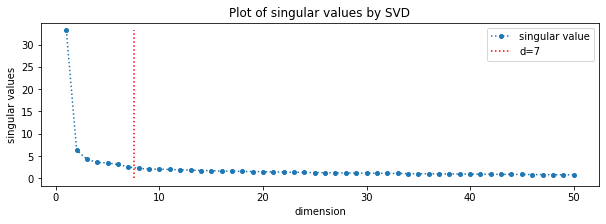

In [17]:
# determine latent dimension
for i in range(T):
    if i==0:
        A_average = A[0]
    else:
        A_average += A[i] 

A_average = A_average/T
U_av,eigval_av,V_av_T = svds(A_average.todense(),k=100)
print(zhu.iterate_zhu(eigval_av[::-1],x=5)) # d=7
d = 7

# plot of eigenvalues
plt.figure(figsize=(10,3))
plot_d = 50
plt.plot(np.linspace(1,plot_d,plot_d),eigval_av[::-1][:plot_d],linestyle =":", marker="o", markersize=4,label="singular value")
plt.vlines(x=d+0.5,ymin=0, ymax= np.max(eigval_av[::-1][:plot_d]), label="d=%s"%(d),color="red",linestyle =":")
plt.xlabel('dimension')
plt.ylabel('singular values')
plt.title('Plot of singular values by SVD')
plt.legend()
plt.show()

## Gibbs sampling for binary PMF model

In [ ]:
# parameter setting
A0_sum_tj, A0_sum_ti = gib.sum_A(A, T, M, N)

# parameters of priors
a_x = 1
b_x = 1
c_x = 0.1

a_y = 1
b_y = 1
c_y = 0.1

alpha_x = 0.1
beta_x = 0.3
alpha_y = 0.5
beta_y = 0.5


### PMF with node dynamics

In [ ]:
# initialisation
x0, y0 = gib.init_xy(A, T, d)
Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = gib.sim_N_I(x0, y0, M, N, T, d, A_dense)

I1 = 1.0 * I0
I1_star = 1.0 * I0_star

# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set1 = {}
y_set1 = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}
N_mat_set = {}

x_set1[0] = x0
y_set1[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

log_likelihood_list = []

num_iteration = 600


for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set1[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set1[num-1], N, d)

    x_set1[num] = gib.sim_xy(y_set1[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set1[num] = gib.sim_xy(x_set1[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set1[num], y_set1[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set1[num], x_set1[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set1[num], y_set1[num], M, N, T, d, A_dense)

    log_likelihood_list.append(gib.log_likelihood_PMF(A_dense, x_set1[num], y_set1[num], Q_set[num], Q_star_set[num], T, M, N))


link_prob1 = gib.possible_link_prob(x_set1, y_set1, theta_set, theta_star_set, M, N, 200)

### Model without node dynamics

In [ ]:
# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set2 = {}
y_set2 = {}
N_mat_set = {}

x_set2[0] = x0
y_set2[0] = y0

log_likelihood_list2 = []

num_iteration = 600

Q1 = np.ones((M, T))
Q1_star = np.ones((N, T))

for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set2[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set2[num-1], N, d)

    x_set2[num] = gib.sim_xy(y_set2[num-1], I1_star, zeta_set[num], Q1, Q1_star, a_x, M, d)
    y_set2[num] = gib.sim_xy(x_set2[num], I1, zeta_star_set[num], Q1_star, Q1, a_y, N, d)

    N_mat_set[num],I1, I1_star = gib.sim_N_I(x_set2[num], y_set2[num], M, N, T, d, A_dense)

    log_likelihood_list2.append(gib.log_likelihood_PMF(A_dense, x_set2[num], y_set2[num], Q1, Q1_star, T, M, N))

theta_set2 = {}
theta_star_set2 = {}
for l in range(num+1):
    theta_set2[l] = np.ones((M,))
    theta_star_set2[l] = np.ones((N,))

link_prob2 = gib.possible_link_prob(x_set2, y_set2, theta_set2, theta_star_set2, M, N, 200)

### Diagnostic plots to test MC convergence

In [18]:
log_likelihood_dy1 =  np.load('gibbs_log_lkelihood21.npy')
log_likelihood_no_dy1 =  np.load('gibbs_log_lkelihood_no_dy21.npy')

log_likelihood_dy2 =  np.load('gibbs_log_lkelihood22.npy')
log_likelihood_no_dy2 =  np.load('gibbs_log_lkelihood_no_dy22.npy')

theta_set = np.load('gibbs_theta2.npy',allow_pickle=True).any()
theta_star_set = np.load('gibbs_theta_star2.npy',allow_pickle=True).any()
x_set1 = np.load('gibbs_x2.npy',allow_pickle=True).any()
y_set1 = np.load('gibbs_y2.npy',allow_pickle=True).any()

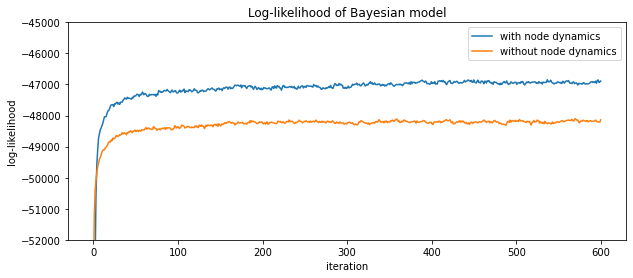

In [19]:
# convergence of log-likelihood
fig, ax1 = plt.subplots(1,1,  figsize=(10,4))
l2 = len(log_likelihood_dy1)
warm_up = 0
plt.plot(np.linspace(warm_up, l2, l2-warm_up), log_likelihood_dy1[warm_up:], label="with node dynamics")
plt.plot(np.linspace(warm_up, l2, l2-warm_up), log_likelihood_no_dy1 [warm_up:], label="without node dynamics")
plt.ylim(-52000, -45000)
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.title("Log-likelihood of Bayesian model")
plt.legend()
plt.show()

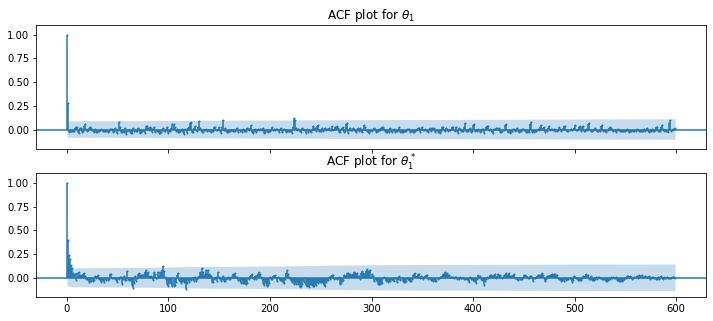

In [21]:
# ACF plot
num_iteration = 600
idx = np.array([0])
pos = int(idx)
select_mc = np.zeros((num_iteration,))
if len(idx)==1:
        pos = int(idx)
        for l in range(1, num_iteration):
            select_mc[l] = theta_set[l][pos]

idx = np.array([0])
pos = int(idx)
select_mc2 = np.zeros((num_iteration,))
if len(idx)==1:
        pos = int(idx)
        for l in range(1, num_iteration):
            select_mc2[l] = theta_star_set[l][pos]


from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True, figsize=(12,5))

plot_acf(select_mc, lags = 599, ax=ax1, markersize=1)
ax1.set_title("ACF plot for $\u03B8_1$")
ax1.set_ylim(-0.2,1.1)

plot_acf(select_mc2, lags = 599, ax=ax2, markersize=1)
ax2.set_title("ACF plot for $\u03B8^*_1$")
ax2.set_ylim(-0.2,1.1)
plt.show()

## Link prediction performance

In [22]:
# load MC with node dynamicsz

x_set1 = np.load('gibbs_x2.npy',allow_pickle=True).any()
y_set1 = np.load('gibbs_y2.npy',allow_pickle=True).any()
theta_set = np.load('gibbs_theta2.npy',allow_pickle=True).any()
theta_star_set = np.load('gibbs_theta_star2.npy',allow_pickle=True).any()

# load MC without node dynamics

x_set2 = np.load('gibbs_x_no_dy2.npy',allow_pickle=True).any()
y_set2 = np.load('gibbs_y_no_dy2.npy',allow_pickle=True).any()


theta_set2 = {}
theta_star_set2 = {}
num = len(y_set2)-1
for l in range(num+1):
    theta_set2[l] = np.ones((M,))
    theta_star_set2[l] = np.ones((N,))

# load all possible links
link_prob1 = np.load('gibbs_link_prob2.npy',allow_pickle=True).any()
link_prob2 = np.load('gibbs_link_prob_no_dy2.npy',allow_pickle=True).any()

### Full set performance

In [27]:
auc_dy = []
auc_no_dy = []
auc_aip = []
auc_cosie = []

### with node dynamicss
print("-------------------with node dynamics-------------------")
for t in range(T,14):
    positive_class, negative_class = gib.binary_class(A[t], M, N)
    pred_prob, actual_label = gib.pfm_pred(positive_class, negative_class, link_prob1, warm_up=200)
    print('The AUC score of PMF is %s at t=%s'%(roc_auc_score(actual_label, pred_prob),t))
    auc_dy.append(roc_auc_score(actual_label, pred_prob))

# without node dynamicss
print("-------------------without node dynamics-------------------")
for t in range(T,14):
    positive_class, negative_class =gib.binary_class(A[t], M, N)
    pred_prob, actual_label = gib.pfm_pred(positive_class, negative_class, link_prob2, warm_up=200)
    print('The AUC score of PMF is %s at t=%s'%(roc_auc_score(actual_label, pred_prob),t))
    auc_no_dy.append(roc_auc_score(actual_label, pred_prob))

-------------------with node dynamics-------------------
The AUC score of PMF is 0.88981789175479 at t=10
The AUC score of PMF is 0.8638330509340965 at t=11
The AUC score of PMF is 0.9264430655092453 at t=12
The AUC score of PMF is 0.9034181726623052 at t=13
-------------------without node dynamics-------------------
The AUC score of PMF is 0.8900284210787128 at t=10
The AUC score of PMF is 0.865478591313091 at t=11
The AUC score of PMF is 0.931520837822854 at t=12
The AUC score of PMF is 0.9075598411144196 at t=13


### Compare with RDPG models

In [28]:
# AIP
X = {}
Y = {}
for t in range(T):
    X_t,Y_t = lanl.dase(A[t],d)
    X[t] = X_t
    Y[t] = Y_t

# COSIE

#compute R_t using MASE for directed graph
hat_X,hat_Y,R = lanl.mase_direct(A,d)

#compute R_average
R_average = lanl.average_mat(R,0,T-1)


for t in range(T,14):
    positive_class, negative_class = gib.binary_class(A[t], M, N)
    # rdpg model
    x,y = lanl.aip(positive_class,X,Y,negative_class)
    print('The AUC score of AIP is %s at t = %s'%(roc_auc_score(y,x), t))
    auc_aip.append(roc_auc_score(y,x))
    
    # cosie model
    x_cosie,y_cosie = lanl.cosie_average(positive_class,hat_X,hat_Y,R_average,negative_class)
    auc_cosie_score = roc_auc_score(y_cosie,np.squeeze(x_cosie))
    print('The AUC score of COSIE is %s at t = %s'%(auc_cosie_score,t))
    auc_cosie.append(auc_cosie_score)

The AUC score of AIP is 0.8447230520945312 at t = 10
The AUC score of COSIE is 0.9069652961790371 at t = 10
The AUC score of AIP is 0.8173826487545583 at t = 11
The AUC score of COSIE is 0.8831801568156405 at t = 11
The AUC score of AIP is 0.9027686759459306 at t = 12
The AUC score of COSIE is 0.9437322238000778 at t = 12
The AUC score of AIP is 0.873113387598154 at t = 13
The AUC score of COSIE is 0.9188121819700767 at t = 13


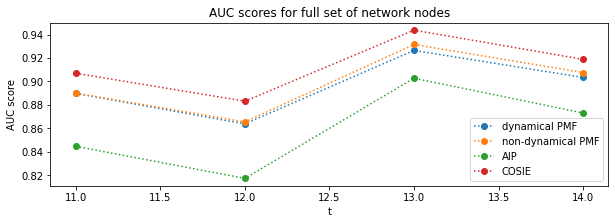

In [29]:
plt.figure(figsize=(10,3))
plt.plot(np.linspace(T+1,14,14-T), auc_dy, linestyle =":", marker="o", markersize=6,label="dynamical PMF")
plt.plot(np.linspace(T+1,14,14-T), auc_no_dy,linestyle =":", marker="o", markersize=6,label="non-dynamical PMF")
plt.plot(np.linspace(T+1,14,14-T), auc_aip,linestyle =":", marker="o", markersize=6,label="AIP")
plt.plot(np.linspace(T+1,14,14-T),auc_cosie,linestyle =":", marker="o", markersize=6,label="COSIE")
plt.xlabel('t')
plt.ylabel('AUC score')
plt.title("AUC scores for full set of network nodes")
plt.legend()
plt.show()

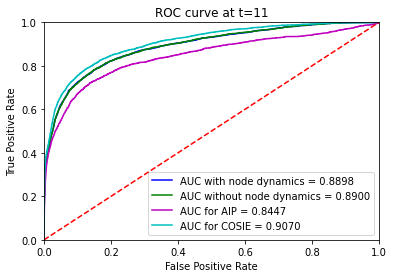

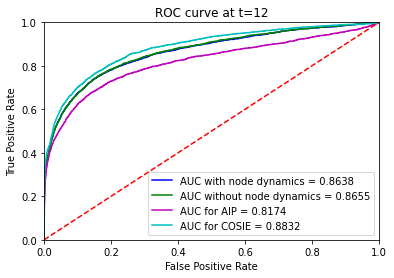

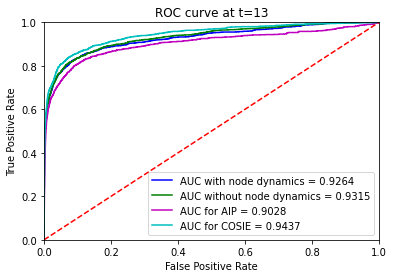

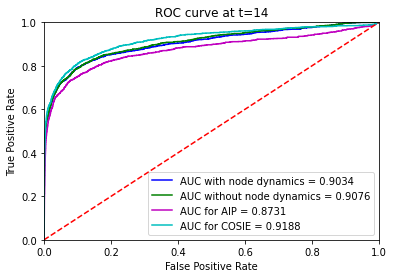

In [30]:
# ROC plot for full set of links by different models
for t in range(T,14):

    filter_pos, filter_neg = gib.binary_class(A[t], M, N)

    
    # AUC score with dynamics
    pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
    fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
    roc_auc1 = metrics.auc(fpr1, tpr1)
      
    # AUC score without dynamics
    pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
    fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
    roc_auc2 = metrics.auc(fpr2, tpr2)        


    # AUC score for AIP
    x,y = lanl.aip(filter_pos,X,Y,filter_neg)
    fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
    roc_auc3 = metrics.auc(fpr3, tpr3)        


    # AUC score for COSIE
    x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
    fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
    roc_auc4 = metrics.auc(fpr4, tpr4)        

    plt.title('ROC curve at t=%s'%(t+1))
    plt.plot(fpr1, tpr1, 'b', label = 'AUC with node dynamics = %0.4f' % roc_auc1)
    plt.plot(fpr2, tpr2, 'g', label = 'AUC without node dynamics = %0.4f' % roc_auc2)
    plt.plot(fpr3, tpr3, 'm', label = 'AUC for AIP = %0.4f' % roc_auc3)
    plt.plot(fpr4, tpr4, 'c', label = 'AUC for COSIE = %0.4f' % roc_auc4)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

## Exploration of activity and quality of link prediction

### Node active levels

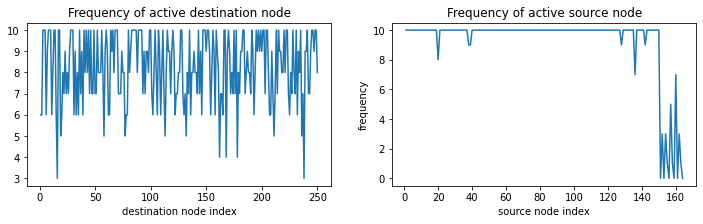

In [31]:
T=10
dest_node_count = gib.freq_node(A, T, N, source_node=False)
source_node_count = gib.freq_node(A, T, M)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
ax1.plot(np.linspace(1,N,N),np.squeeze(dest_node_count))
ax1.set_title("Frequency of active destination node")
ax1.set_xlabel("destination node index")

ax2.plot(np.linspace(1,M,M),np.squeeze(source_node_count))
ax2.set_title("Frequency of active source node")
ax2.set_xlabel("source node index")
ax2.set_ylabel("frequency")
plt.show()

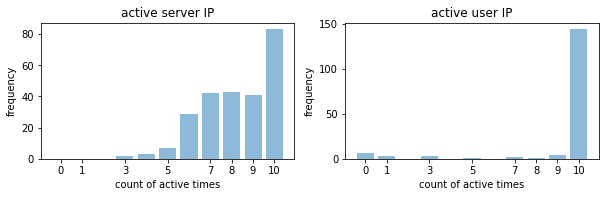

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(10,2.5))


unique_xlabel = np.sort(np.unique(dest_node_count))
correspond_count = np.array([np.sum(dest_node_count==unique_xlabel[i])for i in range(len(unique_xlabel))])


unique_xlabel2 = np.sort(np.unique(source_node_count))
correspond_count2 = np.array([np.sum(source_node_count==unique_xlabel2[i])for i in range(len(unique_xlabel2))])

ax1.bar(unique_xlabel, correspond_count , align='center', alpha=0.5)
ax1.set_xticks(unique_xlabel)
ax1.set_ylabel('frequency')
ax1.set_xlabel("count of active times")
ax1.set_title('active server IP')

ax2.bar(unique_xlabel2, correspond_count2, align='center', alpha=0.5)
ax2.set_xticks(unique_xlabel2)
ax2.set_ylabel('frequency')
ax2.set_xlabel("count of active times")
ax2.set_title('active user IP')
plt.show()

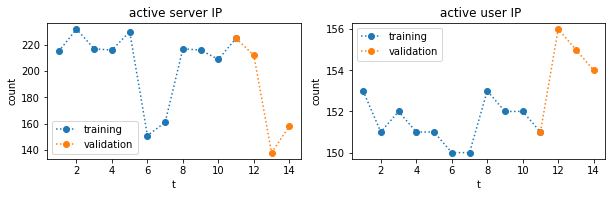

In [33]:
# number of links at each time

dest_dynamical_count = []
source_dynamical_count = []

for t in range(14):
    # dest
    dest_dynamical_count.append(np.sum(np.sum(A[t],axis=0)>0))
    # source
    source_dynamical_count.append(np.sum(np.sum(A[t],axis=1)>0))

T=10
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(10,2.5))
ax1.plot(np.linspace(1,T+1,T+1), dest_dynamical_count[:T+1],linestyle =":", marker="o", markersize=6, label="training")
ax1.plot(np.linspace(T+1,14,14-T), dest_dynamical_count[T:],linestyle =":", marker="o", markersize=6, label="validation")
ax1.legend()
ax1.set_xlabel("t")
ax1.set_ylabel("count")
ax1.set_title(" active server IP")

ax2.plot(np.linspace(1,T+1,T+1), source_dynamical_count[:T+1],linestyle =":", marker="o", markersize=6, label="training")
ax2.plot(np.linspace(T+1,14,14-T), source_dynamical_count[T:],linestyle =":", marker="o", markersize=6, label="validation")
ax2.set_xlabel("t")
ax2.legend()
ax2.set_ylabel("count")
ax2.set_title(" active user IP")

plt.show()


### Subset the graphs on different levels of node activities

#### taking subsets of source nodes

In [34]:
frequency_count = np.sort(np.unique(source_node_count[0]))[::-1]
frequency_count

array([10.,  9.,  8.,  7.,  5.,  3.,  1.,  0.])

In [35]:
# store AUC 
auc_dynamics3 = np.zeros((len(frequency_count),4))
auc_no_dynamics3 = np.zeros((len(frequency_count),4))
auc_aip3 = np.zeros((len(frequency_count),4))
auc_cosie3 = np.zeros((len(frequency_count),4))

# filter out the source nodes which are active with given frequency
for idx, freq in enumerate(frequency_count):
    picked_node_idx = np.linspace(1, M, M)[source_node_count[0]==freq]-1
    for t in range(T,14):
        filter_pos, filter_neg = gib.select_idx_class(A, A[t], T, picked_node_idx)
        if filter_pos.shape[0]>0:
    
            # AUC score with dynamics
            pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
            fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
            roc_auc1 = metrics.auc(fpr1, tpr1)
            auc_dynamics3[idx, t-T] = roc_auc1 
      
            # AUC score without dynamics
            pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
            fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
            roc_auc2 = metrics.auc(fpr2, tpr2)        
            auc_no_dynamics3[idx, t-T] = roc_auc2

            # AUC score for AIP
            x,y = lanl.aip(filter_pos,X,Y,filter_neg)
            fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
            roc_auc3 = metrics.auc(fpr3, tpr3)    
            auc_aip3[idx, t-T] = roc_auc3

            # AUC score for COSIE
            x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
            fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
            roc_auc4 = metrics.auc(fpr4, tpr4)    
            auc_cosie3[idx, t-T] = roc_auc4

           
        else:
            auc_dynamics3[idx, t-T] = -1
            auc_no_dynamics3[idx, t-T] = -1
            auc_aip3[idx, t-T] = -1
            auc_cosie3[idx, t-T] = -1

In [36]:
# pick some subsets which dynamic PMF model outperforms than others
x_idx, y_idx = np.where(auc_cosie3<auc_dynamics3)
print("------------------------------------ PMF and COSIE ------------------------------------")
for num in range(6):
    i = x_idx[num]
    j = y_idx[num]
    print("for t=%s, freq=%s, AUC for dynamical PMF = %s and for COSIE = %s"%(j+T,frequency_count[i],auc_dynamics3[i,j],auc_cosie3[i,j]))

print("------------------------------------ PMF with and withoud dynamics ------------------------------------")
for num in range(6):
    i = x_idx[num]
    j = y_idx[num]
    print("for t=%s, freq=%s, AUC for dynamical PMF = %s and for no dynamical = %s"%(j+T,frequency_count[i],auc_dynamics3[i,j],auc_no_dynamics3[i,j]))

------------------------------------ PMF and COSIE ------------------------------------
for t=13, freq=9.0, AUC for dynamical PMF = 0.9394692665289256 and for COSIE = 0.938436208677686
for t=11, freq=8.0, AUC for dynamical PMF = 0.8575440786394133 and for COSIE = 0.8394445311281012
for t=13, freq=8.0, AUC for dynamical PMF = 0.9924863387978142 and for COSIE = 0.9883879781420766
for t=12, freq=7.0, AUC for dynamical PMF = 0.9875217185278786 and for COSIE = 0.9815195071868583
for t=13, freq=7.0, AUC for dynamical PMF = 0.9952614120991945 and for COSIE = 0.9924182593587111
for t=11, freq=5.0, AUC for dynamical PMF = 0.8226768968456948 and for COSIE = 0.6985294117647058
------------------------------------ PMF with and withoud dynamics ------------------------------------
for t=13, freq=9.0, AUC for dynamical PMF = 0.9394692665289256 and for no dynamical = 0.9402440599173554
for t=11, freq=8.0, AUC for dynamical PMF = 0.8575440786394133 and for no dynamical = 0.8498985801217039
for t=13, f

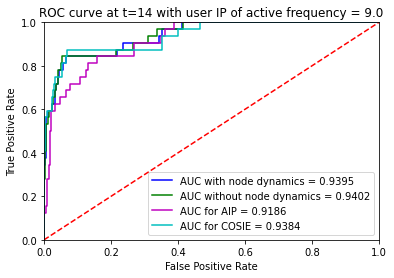

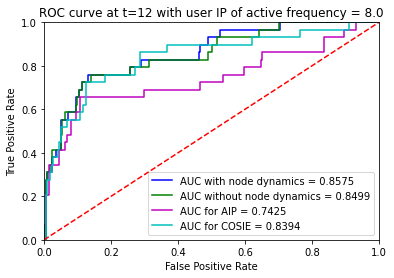

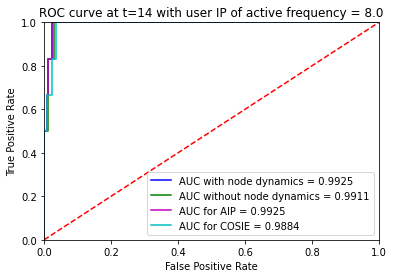

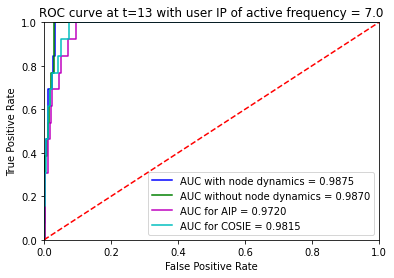

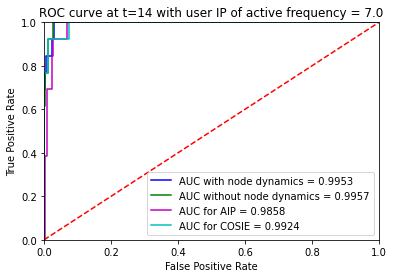

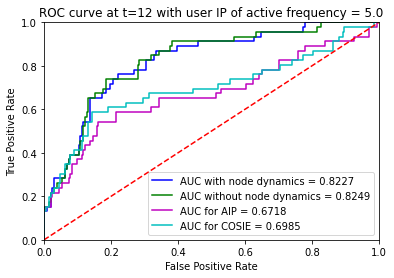

In [37]:
# filter out the source nodes which are active with given frequency
for num in range(6):
    t = y_idx[num] + T 
    freq = frequency_count[x_idx[num]]
    picked_node_idx = np.linspace(1, M, M)[source_node_count[0]==freq]-1
    filter_pos, filter_neg = gib.select_idx_class(A, A[t], T, picked_node_idx)
    
    # AUC score with dynamics
    pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
    fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
    roc_auc1 = metrics.auc(fpr1, tpr1)
      
    # AUC score without dynamics
    pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
    fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
    roc_auc2 = metrics.auc(fpr2, tpr2)        

    # AUC score for AIP
    x,y = lanl.aip(filter_pos,X,Y,filter_neg)
    fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
    roc_auc3 = metrics.auc(fpr3, tpr3)        

    # AUC score for COSIE
    x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
    fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
    roc_auc4 = metrics.auc(fpr4, tpr4)        

    plt.title('ROC curve at t=%s with user IP of active frequency = %s'%(t+1,freq))
    plt.plot(fpr1, tpr1, 'b', label = 'AUC with node dynamics = %0.4f' % roc_auc1)
    plt.plot(fpr2, tpr2, 'g', label = 'AUC without node dynamics = %0.4f' % roc_auc2)
    plt.plot(fpr3, tpr3, 'm', label = 'AUC for AIP = %0.4f' % roc_auc3)
    plt.plot(fpr4, tpr4, 'c', label = 'AUC for COSIE = %0.4f' % roc_auc4)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### taking subsets of destination nodes

In [38]:
frequency_count2 = np.sort(np.unique(dest_node_count[0]))[::-1]
frequency_count2

array([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.])

In [39]:
# store AUC 
auc_dynamics4 = np.zeros((len(frequency_count2),4))
auc_no_dynamics4 = np.zeros((len(frequency_count2),4))
auc_aip4 = np.zeros((len(frequency_count),4))
auc_cosie4 = np.zeros((len(frequency_count),4))


# filter out the source nodes which are active with given frequency
for idx, freq in enumerate(frequency_count2):
    picked_node_idx = np.linspace(1, N, N)[dest_node_count[0]==freq]-1
    
    for t in range(T,14):
        filter_pos, filter_neg = gib.select_idx_class(A, A[t], T, picked_node_idx,source_node=False)
        if filter_pos.shape[0]>0:
    
            # AUC score with dynamics
            pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
            fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
            roc_auc1 = metrics.auc(fpr1, tpr1)
            auc_dynamics4[idx, t-T] = roc_auc1 
      
            # AUC score without dynamics
            pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
            fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
            roc_auc2 = metrics.auc(fpr2, tpr2)        
            auc_no_dynamics4[idx, t-T] = roc_auc2

            # AUC score for AIP
            x,y = lanl.aip(filter_pos,X,Y,filter_neg)
            fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
            roc_auc3 = metrics.auc(fpr3, tpr3)    
            auc_aip4[idx, t-T] = roc_auc3

            # AUC score for COSIE
            x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
            fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
            roc_auc4 = metrics.auc(fpr4, tpr4)    
            auc_cosie4[idx, t-T] = roc_auc4
        
        else:
            auc_dynamics4[idx, t-T] = -1
            auc_no_dynamics4[idx, t-T] = -1
            auc_aip4[idx, t-T] = -1
            auc_cosie4[idx, t-T] = -1

In [40]:
idx_better = np.where(auc_cosie4<auc_dynamics4)
print(idx_better)

x_idx, y_idx = np.where(auc_cosie4<auc_dynamics4)
print("------------------------------------ PMF and COSIE ------------------------------------")
for num in range(len(idx_better )):
    i = x_idx[num]
    j = y_idx[num]
    print("for t=%s, freq=%s, AUC for dynamical PMF = %s and for COSIE = %s"%(j+T,frequency_count2[i],auc_dynamics4[i,j],auc_cosie4[i,j]))

print("------------------------------------ PMF with and withoud dynamics ------------------------------------")
for num in range(len(idx_better )):
    i = x_idx[num]
    j = y_idx[num]
    print("for t=%s, freq=%s, AUC for dynamical PMF = %s and for no dynamical = %s"%(j+T,frequency_count2[i],auc_dynamics4[i,j],auc_no_dynamics4[i,j]))

(array([6, 6, 6, 7]), array([0, 2, 3, 0]))
------------------------------------ PMF and COSIE ------------------------------------
for t=10, freq=4.0, AUC for dynamical PMF = 0.7412190082644627 and for COSIE = 0.7404442148760331
for t=12, freq=4.0, AUC for dynamical PMF = 0.7377551020408163 and for COSIE = 0.4091836734693878
------------------------------------ PMF with and withoud dynamics ------------------------------------
for t=10, freq=4.0, AUC for dynamical PMF = 0.7412190082644627 and for no dynamical = 0.7412190082644629
for t=12, freq=4.0, AUC for dynamical PMF = 0.7377551020408163 and for no dynamical = 0.7336734693877551


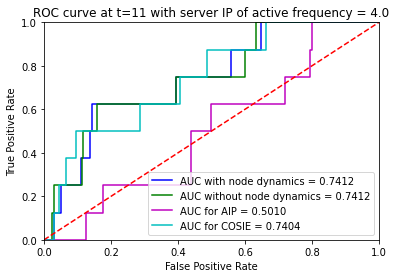

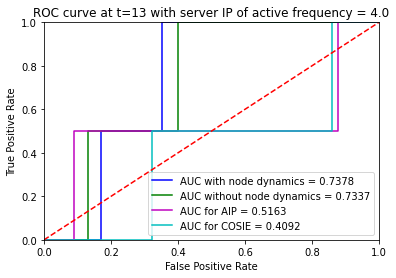

In [41]:
# filter out the source nodes which are active with given frequency
for num in range(2):
    t = y_idx[num] + T 
    freq = frequency_count2[x_idx[num]]
    picked_node_idx = np.linspace(1, N, N)[dest_node_count[0]==freq]-1
    filter_pos, filter_neg = gib.select_idx_class(A, A[t], T, picked_node_idx, source_node=False)

    # AUC score with dynamics
    pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
    fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
    roc_auc1 = metrics.auc(fpr1, tpr1)
      
    # AUC score without dynamics
    pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
    fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
    roc_auc2 = metrics.auc(fpr2, tpr2)        

    # AUC score for AIP
    x,y = lanl.aip(filter_pos,X,Y,filter_neg)
    fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
    roc_auc3 = metrics.auc(fpr3, tpr3)        

    # AUC score for COSIE
    x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
    fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
    roc_auc4 = metrics.auc(fpr4, tpr4)        
        
    plt.title('ROC curve at t=%s with server IP of active frequency = %s'%(t+1,freq))
    plt.plot(fpr1, tpr1, 'b', label = 'AUC with node dynamics = %0.4f' % roc_auc1)
    plt.plot(fpr2, tpr2, 'g', label = 'AUC without node dynamics = %0.4f' % roc_auc2)
    plt.plot(fpr3, tpr3, 'm', label = 'AUC for AIP = %0.4f' % roc_auc3)
    plt.plot(fpr4, tpr4, 'c', label = 'AUC for COSIE = %0.4f' % roc_auc4)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()


In [42]:
# filter out the source nodes which are active with given frequency
pos_rate = []
for idx, freq in enumerate([3,4,5]):
    picked_node_idx = np.linspace(1, N, N)[dest_node_count[0]==freq]-1
    
    for t in range(T,14):
        filter_pos, filter_neg = gib.select_idx_class(A, A[t], T, picked_node_idx,source_node=False)
        print("t=%s, freq=%s, no. of positive class=%s, no. of negative class=%s"%(t+1, freq,filter_pos.shape[0],filter_neg.shape[0] ))
        pos_rate.append(filter_pos.shape[0]/(filter_pos.shape[0]+filter_neg.shape[0]))

t=11, freq=3, no. of positive class=12, no. of negative class=316
t=12, freq=3, no. of positive class=7, no. of negative class=321
t=13, freq=3, no. of positive class=1, no. of negative class=327
t=14, freq=3, no. of positive class=3, no. of negative class=325
t=11, freq=4, no. of positive class=8, no. of negative class=484
t=12, freq=4, no. of positive class=1, no. of negative class=491
t=13, freq=4, no. of positive class=2, no. of negative class=490
t=14, freq=4, no. of positive class=1, no. of negative class=491
t=11, freq=5, no. of positive class=12, no. of negative class=1136
t=12, freq=5, no. of positive class=19, no. of negative class=1129
t=13, freq=5, no. of positive class=3, no. of negative class=1145
t=14, freq=5, no. of positive class=3, no. of negative class=1145


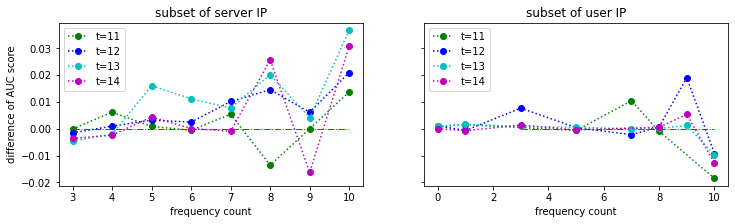

In [43]:
# plot AUC differences
diff1 = (auc_dynamics3-auc_no_dynamics3)
diff2 = (auc_dynamics4-auc_no_dynamics4)

xlab_t10 = frequency_count[::-1][auc_dynamics3[:,0]!=-1]
ylab_t10 = diff1[:,0][auc_dynamics3[:,0]!=-1]

xlab_t12 = frequency_count[::-1][auc_dynamics3[:,2]!=-1]
ylab_t12 = diff1[:,2][auc_dynamics3[:,2]!=-1]

xlab_t13 = frequency_count[::-1][auc_dynamics3[:,3]!=-1]
ylab_t13 = diff1[:,3][auc_dynamics3[:,3]!=-1]


fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(12,3))

ax1.plot(frequency_count2[::-1], diff2[:,0],label="t=11", color="g",linestyle =":", marker="o", markersize=6)
ax1.plot(frequency_count2[::-1], diff2[:,1],label="t=12", color="b",linestyle =":", marker="o", markersize=6)
ax1.plot(frequency_count2[::-1], diff2[:,2],label="t=13", color="c",linestyle =":", marker="o", markersize=6)
ax1.plot(frequency_count2[::-1], diff2[:,3],label="t=14", color="m",linestyle =":", marker="o", markersize=6)
ax1.hlines(y=0,xmin=3,xmax=10, color="r",linestyle="-.",linewidth=1)
ax1.legend()
ax1.set_ylabel("difference of AUC score")
ax1.set_xlabel("frequency count")
ax1.set_title("subset of server IP")

ax2.plot(xlab_t10, ylab_t10,label="t=11", color="g",linestyle =":", marker="o", markersize=6)
ax2.plot(frequency_count[::-1], diff1[:,1],label="t=12", color="b",linestyle =":", marker="o", markersize=6)
ax2.plot(xlab_t12, ylab_t12,label="t=13", color="c",linestyle =":", marker="o", markersize=6)
ax2.plot(xlab_t13, ylab_t13,label="t=14", color="m",linestyle =":", marker="o", markersize=6)
ax2.hlines(y=0,xmin=3,xmax=10, color="r",linestyle="-.",linewidth=1)
ax2.legend()
ax2.set_xlabel("frequency count")
ax2.set_title("subset of user IP")

plt.show()

## New link prediction

In [44]:
#filter out all the observed links
A_sum = np.zeros((M, N))
for t in range(T):
    A_sum += A_dense[t]

print("The new link rate is %s"%(np.sum(A_sum==0)/(M*N)))

new_link_i, new_link_j = np.where(A_sum==0)

The new link rate is 0.7705853658536586


In [45]:
def new_link_class(A, new_link_i, new_link_j, M, N):
    negative_class = np.zeros((M*N,2))
    positive_class = np.zeros((M*N,2))
     
    neg_count = 0 
    pos_count = 0

    for l in range(len(new_link_i)):
        if A[new_link_i[l], new_link_j[l]]==0:
            negative_class[neg_count,:] = np.array([new_link_i[l], new_link_j[l]])
            neg_count += 1
        
        else:
            positive_class[pos_count,:] = np.array([new_link_i[l], new_link_j[l]])
            pos_count += 1
    

    return positive_class[:pos_count,:],negative_class[:neg_count,:]

### Full set

-------------------with node dynamics-------------------
The AUC score of PMF is 0.7464951065250747 at t=10
The AUC score of PMF is 0.7009618717710883 at t=11
The AUC score of PMF is 0.6998275339109947 at t=12
The AUC score of PMF is 0.6638337769846981 at t=13
-------------------without node dynamics-------------------
The AUC score of PMF is 0.7479140534394327 at t=10
The AUC score of PMF is 0.7076111910180922 at t=11
The AUC score of PMF is 0.7357630644062806 at t=12
The AUC score of PMF is 0.6866385213819843 at t=13
-------------------AIP-------------------
The AUC score of AIP is 0.6269127404405547 at t = 10
The AUC score of AIP is 0.577502521496567 at t = 11
The AUC score of AIP is 0.5802058548835913 at t = 12
The AUC score of AIP is 0.5330016502871776 at t = 13
-------------------COSIE-------------------
The AUC score of COSIE is 0.7953931996496146 at t = 10
The AUC score of COSIE is 0.7681878901424296 at t = 11
The AUC score of COSIE is 0.7952392956981115 at t = 12
The AUC score

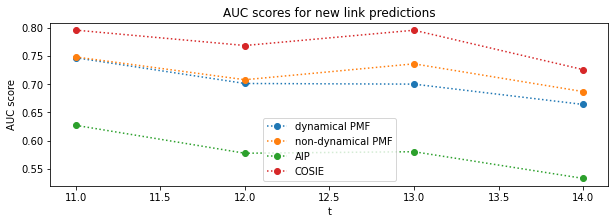

In [46]:
auc_dy = []
auc_no_dy = []
auc_aip = []
auc_cosie = []

### with node dynamicss
print("-------------------with node dynamics-------------------")
for t in range(T,14):
    new_link_positive_class, new_link_negative_class = new_link_class(A_dense[t], new_link_i, new_link_j, M, N)
    pred_prob, actual_label = gib.pfm_pred(new_link_positive_class, new_link_negative_class, link_prob1, warm_up=200)
    auc_dy.append(roc_auc_score(actual_label, pred_prob))
    print('The AUC score of PMF is %s at t=%s'%(roc_auc_score(actual_label, pred_prob),t))



# without node dynamicss
print("-------------------without node dynamics-------------------")
for t in range(T,14):
    new_link_positive_class, new_link_negative_class = new_link_class(A_dense[t], new_link_i, new_link_j, M, N)
    pred_prob, actual_label = gib.pfm_pred(new_link_positive_class, new_link_negative_class, link_prob2, warm_up=200)
    auc_no_dy.append(roc_auc_score(actual_label, pred_prob))
    print('The AUC score of PMF is %s at t=%s'%(roc_auc_score(actual_label, pred_prob),t))


print("-------------------AIP-------------------")
for t in range(T,14):
    new_link_positive_class, new_link_negative_class = new_link_class(A_dense[t], new_link_i, new_link_j, M, N)

    # rdpg model
    x,y = lanl.aip(new_link_positive_class, X, Y, new_link_negative_class)
    auc_aip.append(roc_auc_score(y,x))
    print('The AUC score of AIP is %s at t = %s'%(roc_auc_score(y,x), t))

print("-------------------COSIE-------------------")
for t in range(T,14):
    new_link_positive_class, new_link_negative_class = new_link_class(A_dense[t], new_link_i, new_link_j, M, N)
    # cosie model
    x_cosie,y_cosie = lanl.cosie_average(new_link_positive_class,hat_X,hat_Y,R_average, new_link_negative_class)
    auc_cosie_score = roc_auc_score(y_cosie,np.squeeze(x_cosie))
    auc_cosie.append(auc_cosie_score)
    print('The AUC score of COSIE is %s at t = %s'%(auc_cosie_score,t))

plt.figure(figsize=(10,3))
plt.plot(np.linspace(T+1,14,14-T), auc_dy, linestyle =":", marker="o", markersize=6,label="dynamical PMF")
plt.plot(np.linspace(T+1,14,14-T), auc_no_dy,linestyle =":", marker="o", markersize=6,label="non-dynamical PMF")
plt.plot(np.linspace(T+1,14,14-T), auc_aip,linestyle =":", marker="o", markersize=6,label="AIP")
plt.plot(np.linspace(T+1,14,14-T),auc_cosie,linestyle =":", marker="o", markersize=6,label="COSIE")
plt.xlabel('t')
plt.ylabel('AUC score')
plt.title("AUC scores for new link predictions")
plt.legend()
plt.show()

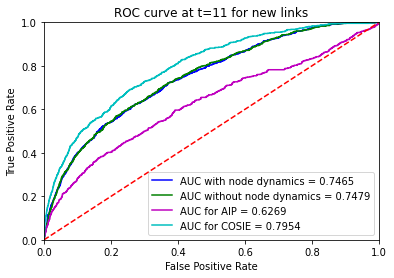

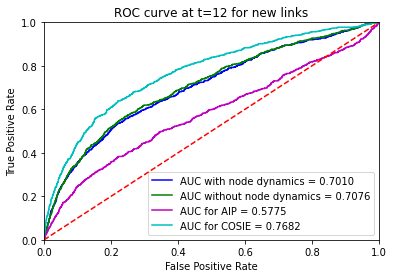

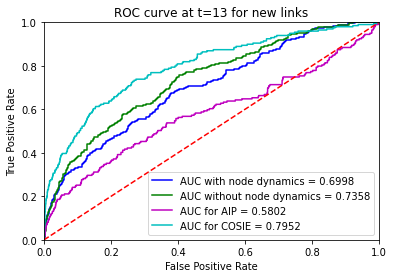

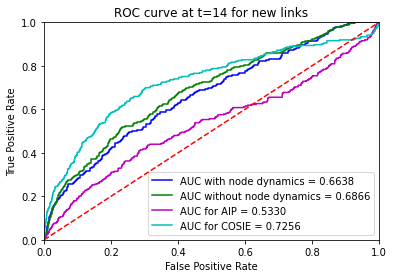

In [47]:
for t in range(T,14):

    filter_pos, filter_neg = new_link_class(A_dense[t], new_link_i, new_link_j, M, N)

    # AUC score with dynamics
    pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
    fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
    roc_auc1 = metrics.auc(fpr1, tpr1)
      
    # AUC score without dynamics
    pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
    fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
    roc_auc2 = metrics.auc(fpr2, tpr2)        

    # AUC score for AIP
    x,y = lanl.aip(filter_pos,X,Y,filter_neg)
    fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
    roc_auc3 = metrics.auc(fpr3, tpr3)        


    # AUC score for COSIE
    x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
    fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
    roc_auc4 = metrics.auc(fpr4, tpr4)       
        
    plt.title('ROC curve at t=%s for new links'%(t+1))
    plt.plot(fpr1, tpr1, 'b', label = 'AUC with node dynamics = %0.4f' % roc_auc1)
    plt.plot(fpr2, tpr2, 'g', label = 'AUC without node dynamics = %0.4f' % roc_auc2)
    plt.plot(fpr3, tpr3, 'm', label = 'AUC for AIP = %0.4f' % roc_auc3)
    plt.plot(fpr4, tpr4, 'c', label = 'AUC for COSIE = %0.4f' % roc_auc4)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()
    

### Taking subset based on frequency of  node activities

In [48]:
dest_node_count = gib.freq_node(A, T, N, source_node=False)
source_node_count = gib.freq_node(A, T, M)

### Take subset of source nodes

In [49]:
frequency_count = np.sort(np.unique(source_node_count[0]))[::-1]
frequency_count

array([10.,  9.,  8.,  7.,  5.,  3.,  1.,  0.])

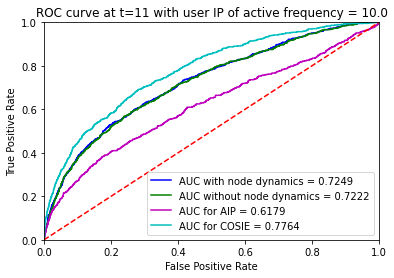

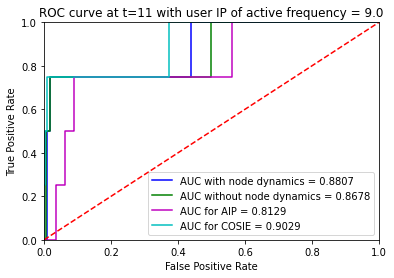

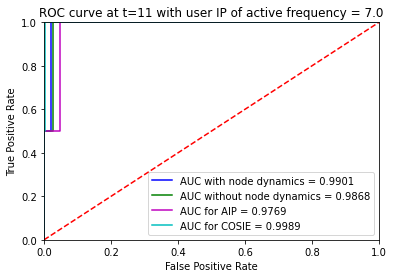

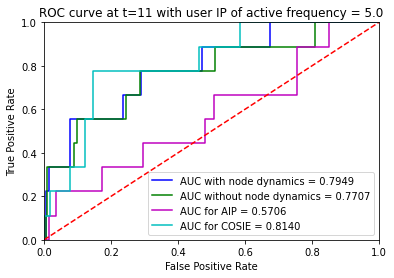

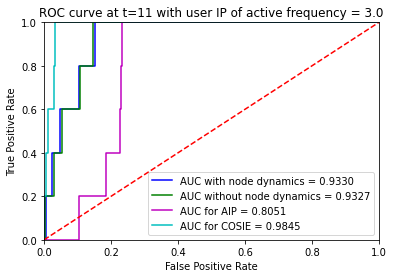

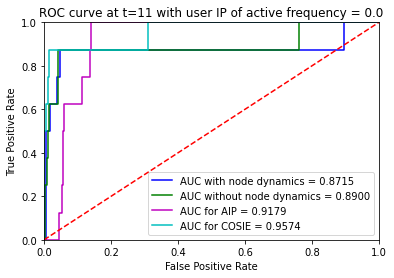

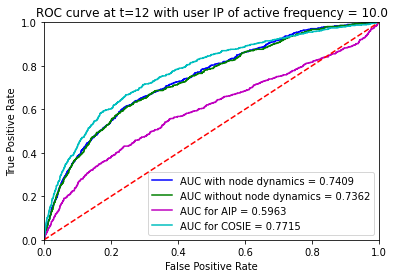

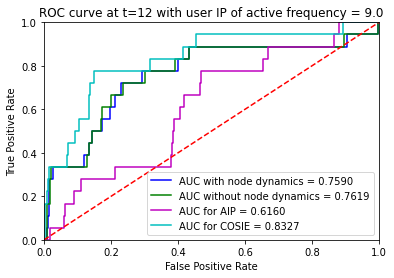

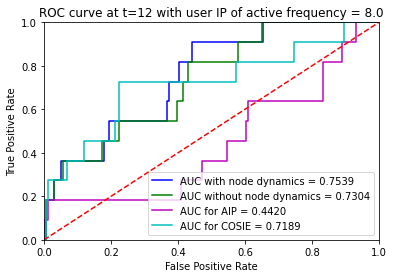

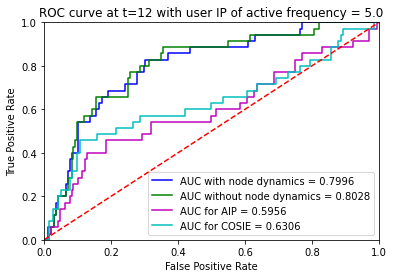

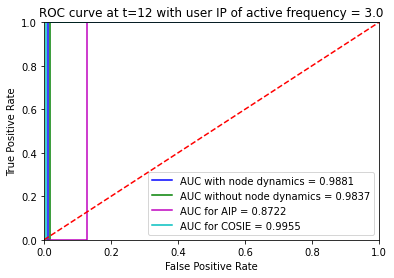

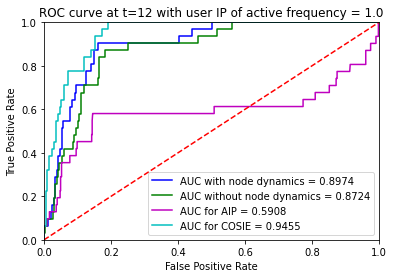

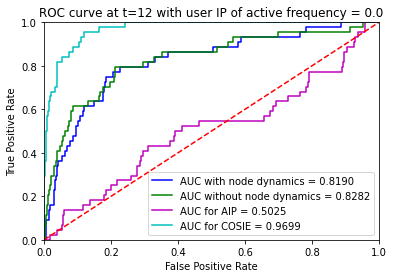

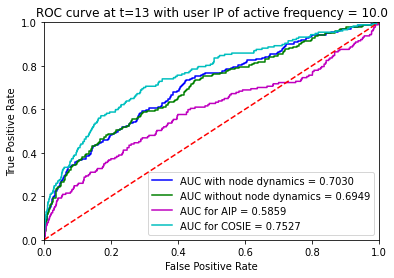

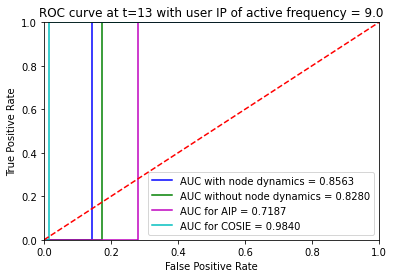

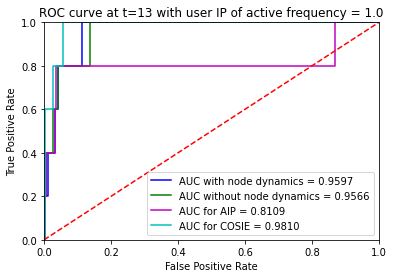

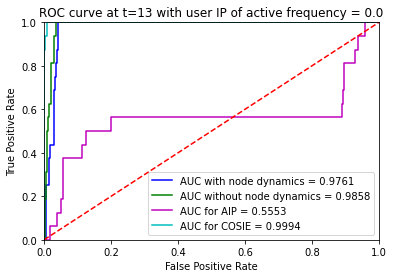

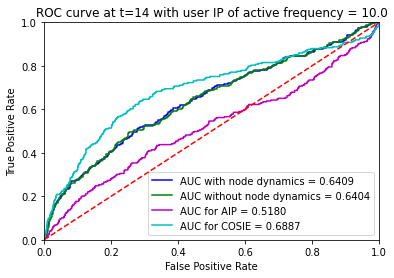

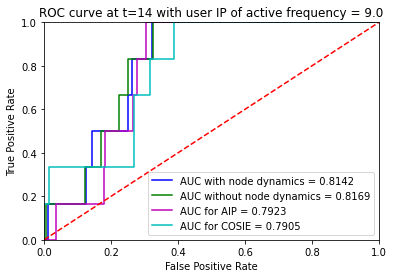

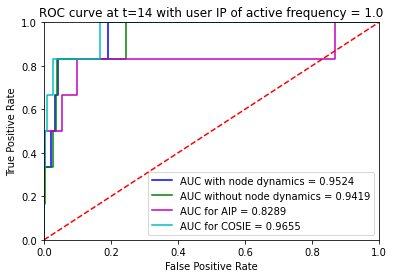

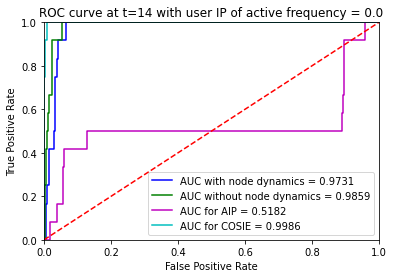

In [50]:
# store AUC 
auc_dynamics3 = np.zeros((len(frequency_count),4))
auc_no_dynamics3 = np.zeros((len(frequency_count),4))
auc_aip3 = np.zeros((len(frequency_count),4))
auc_cosie3 = np.zeros((len(frequency_count),4))

# filter out the source nodes which are active with given frequency
for t in range(T,14):
    new_link_positive_class, new_link_negative_class = new_link_class(A_dense[t], new_link_i, new_link_j, M, N)
    for idx, freq in enumerate(frequency_count):
        picked_node_idx = np.linspace(1, M, M)[source_node_count[0]==freq]-1
    
        
        filter_pos = new_link_positive_class[[i in picked_node_idx for i in new_link_positive_class[:,0] ],:]
        filter_neg = new_link_negative_class[[i in picked_node_idx for i in new_link_negative_class[:,0] ],:]

        if filter_pos.shape[0]>0:
    
            # AUC score with dynamics
            pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
            fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
            roc_auc1 = metrics.auc(fpr1, tpr1)
            auc_dynamics3[idx, t-T] = roc_auc1 
      
            # AUC score without dynamics
            pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
            fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
            roc_auc2 = metrics.auc(fpr2, tpr2)        
            auc_no_dynamics3[idx, t-T] = roc_auc2

            # AUC score for AIP
            x,y = lanl.aip(filter_pos,X,Y,filter_neg)
            fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
            roc_auc3 = metrics.auc(fpr3, tpr3)    
            auc_aip3[idx, t-T] = roc_auc3

            # AUC score for COSIE
            x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
            fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
            roc_auc4 = metrics.auc(fpr4, tpr4)    
            auc_cosie3[idx, t-T] = roc_auc4

            plt.title('ROC curve at t=%s with user IP of active frequency = %s'%(t+1,freq))
            plt.plot(fpr1, tpr1, 'b', label = 'AUC with node dynamics = %0.4f' % roc_auc1)
            plt.plot(fpr2, tpr2, 'g', label = 'AUC without node dynamics = %0.4f' % roc_auc2)
            plt.plot(fpr3, tpr3, 'm', label = 'AUC for AIP = %0.4f' % roc_auc3)
            plt.plot(fpr4, tpr4, 'c', label = 'AUC for COSIE = %0.4f' % roc_auc4)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()

           
        else:
            auc_dynamics3[idx, t-T] = -1
            auc_no_dynamics3[idx, t-T] = -1
            auc_aip3[idx, t-T] = -1
            auc_cosie3[idx, t-T] = -1

### Take subset of destination nodes

In [51]:
frequency_count2 = np.sort(np.unique(dest_node_count[0]))[::-1]
frequency_count2

array([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.])

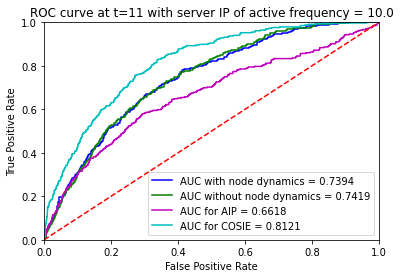

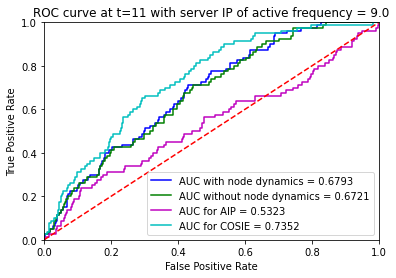

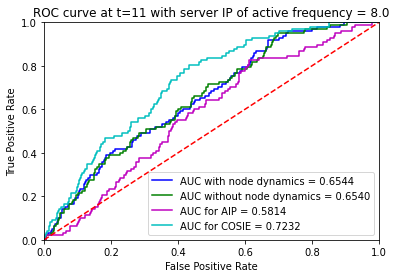

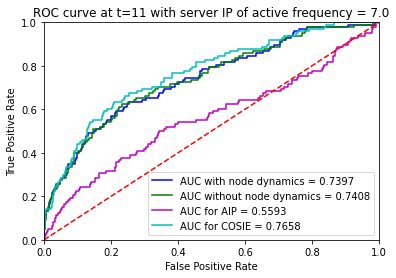

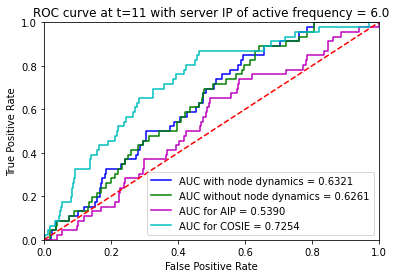

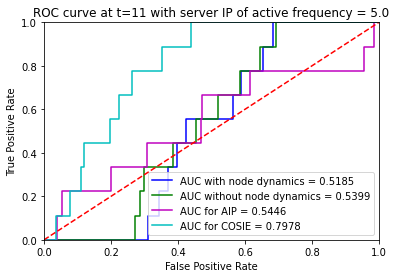

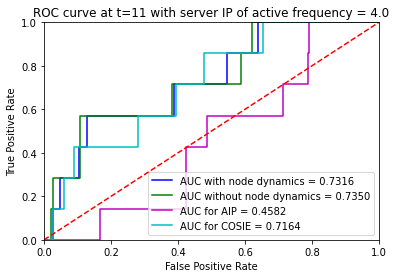

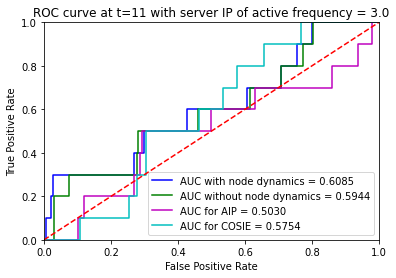

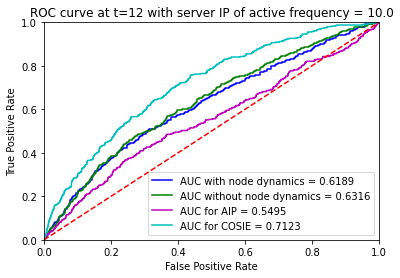

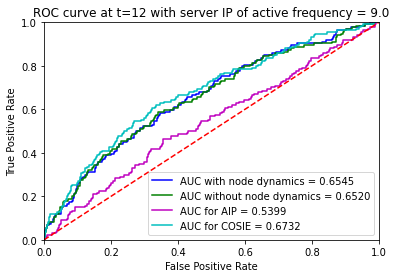

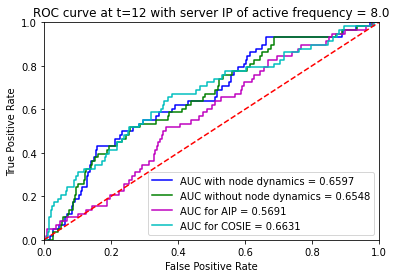

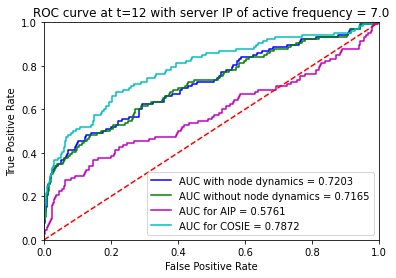

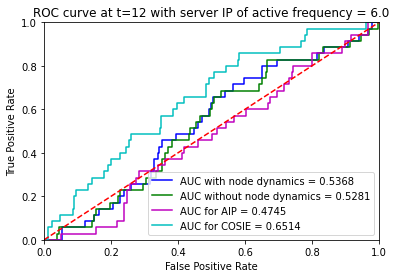

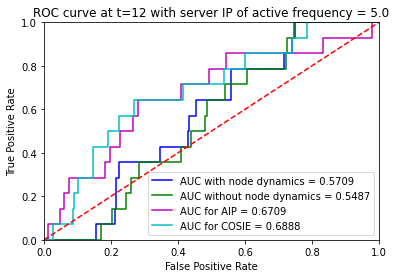

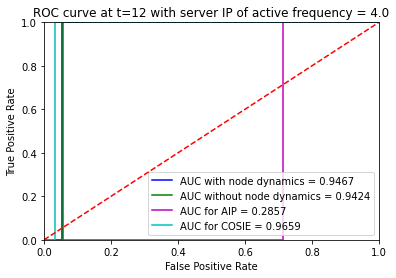

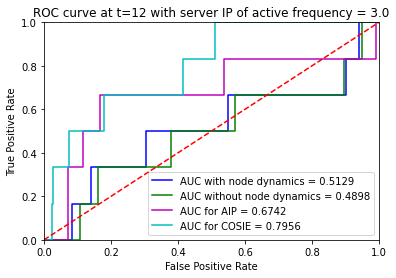

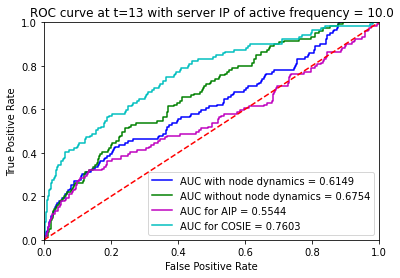

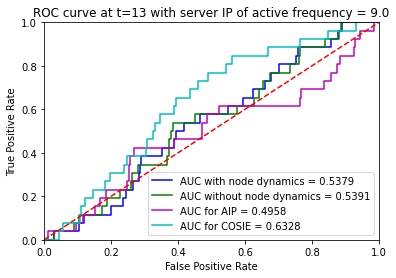

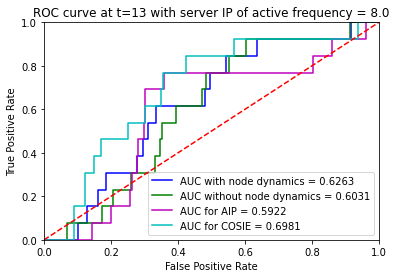

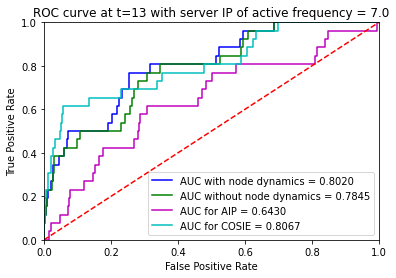

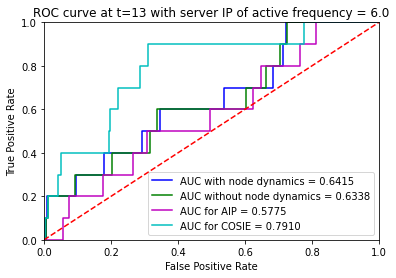

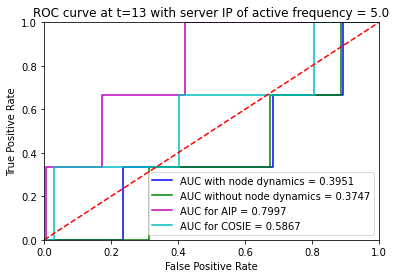

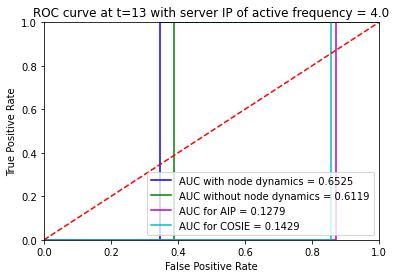

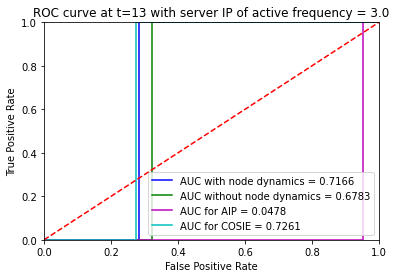

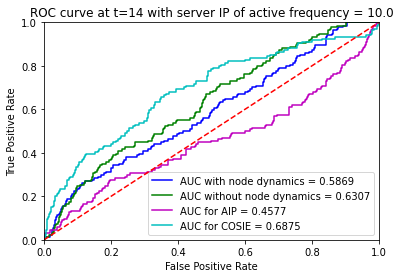

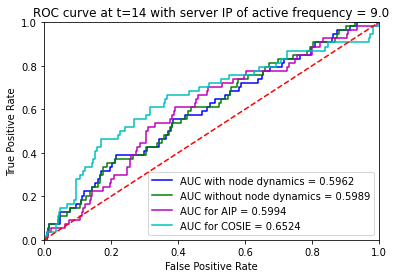

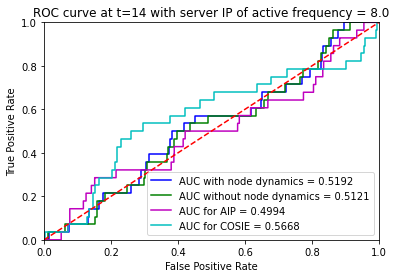

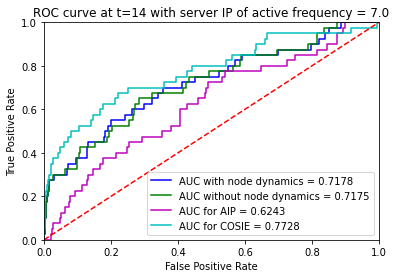

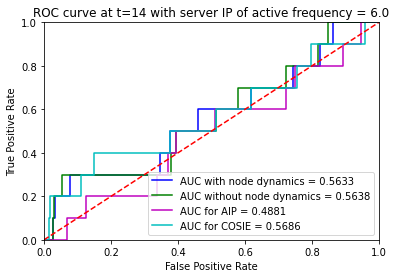

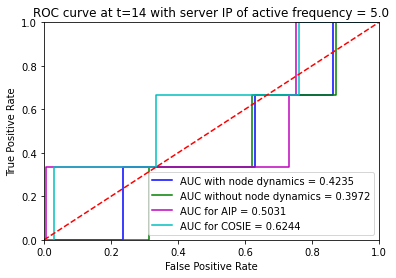

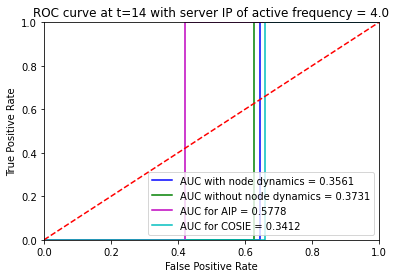

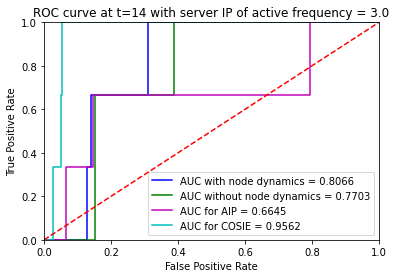

In [52]:
# store AUC 
auc_dynamics4 = np.zeros((len(frequency_count2),4))
auc_no_dynamics4 = np.zeros((len(frequency_count2),4))
auc_aip4 = np.zeros((len(frequency_count),4))
auc_cosie4 = np.zeros((len(frequency_count),4))


# filter out the source nodes which are active with given frequency

for t in range(T,14):
    new_link_positive_class, new_link_negative_class = new_link_class(A_dense[t], new_link_i, new_link_j, M, N)
    for idx, freq in enumerate(frequency_count2):
        picked_node_idx = np.linspace(1, N, N)[dest_node_count[0]==freq]-1
        filter_pos = new_link_positive_class[[i in picked_node_idx for i in new_link_positive_class[:,1] ],:]
        filter_neg = new_link_negative_class[[i in picked_node_idx for i in new_link_negative_class[:,1] ],:]
        if filter_pos.shape[0]>0:
    
            # AUC score with dynamics
            pred_prob1, actual_label1 = gib.pfm_pred(filter_pos, filter_neg, link_prob1, warm_up=200)
            fpr1, tpr1, threshold1 = metrics.roc_curve(actual_label1, pred_prob1)
            roc_auc1 = metrics.auc(fpr1, tpr1)
            auc_dynamics4[idx, t-T] = roc_auc1 
      
            # AUC score without dynamics
            pred_prob2, actual_label2 = gib.pfm_pred(filter_pos, filter_neg, link_prob2, warm_up=200)
            fpr2, tpr2, threshold2 = metrics.roc_curve(actual_label2, pred_prob2)
            roc_auc2 = metrics.auc(fpr2, tpr2)        
            auc_no_dynamics4[idx, t-T] = roc_auc2

            # AUC score for AIP
            x,y = lanl.aip(filter_pos,X,Y,filter_neg)
            fpr3, tpr3, threshold3 = metrics.roc_curve(y, x)
            roc_auc3 = metrics.auc(fpr3, tpr3)    
            auc_aip4[idx, t-T] = roc_auc3

            # AUC score for COSIE
            x_cosie,y_cosie = lanl.cosie_average(filter_pos,hat_X,hat_Y,R_average,filter_neg)
            fpr4, tpr4, threshold4 = metrics.roc_curve(y_cosie,np.squeeze(x_cosie))
            roc_auc4 = metrics.auc(fpr4, tpr4)    
            auc_cosie4[idx, t-T] = roc_auc4

            plt.title('ROC curve at t=%s with server IP of active frequency = %s'%(t+1,freq))
            plt.plot(fpr1, tpr1, 'b', label = 'AUC with node dynamics = %0.4f' % roc_auc1)
            plt.plot(fpr2, tpr2, 'g', label = 'AUC without node dynamics = %0.4f' % roc_auc2)
            plt.plot(fpr3, tpr3, 'm', label = 'AUC for AIP = %0.4f' % roc_auc3)
            plt.plot(fpr4, tpr4, 'c', label = 'AUC for COSIE = %0.4f' % roc_auc4)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.savefig('ROC_t_%s_dest_freq_%s_new_link.pdf'%(t,freq), format="pdf", bbox_inches="tight")
            plt.show()
        
        else:
            auc_dynamics4[idx, t-T] = -1
            auc_no_dynamics4[idx, t-T] = -1
            auc_aip4[idx, t-T] = -1
            auc_cosie4[idx, t-T] = -1

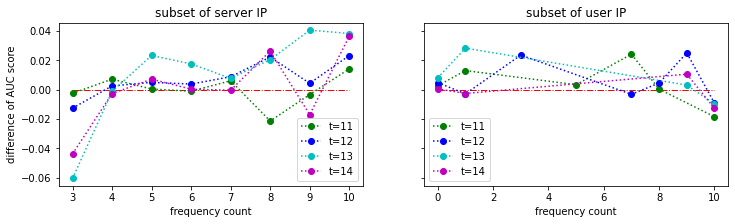

In [53]:
diff1= auc_dynamics3 - auc_no_dynamics3
diff2 = auc_dynamics4 - auc_no_dynamics4


xlab_t10 = frequency_count[::-1][auc_dynamics3[:,0]!=-1]
ylab_t10 = diff1[:,0][auc_dynamics3[:,0]!=-1]

xlab_t11 = frequency_count[::-1][auc_dynamics3[:,1]!=-1]
ylab_t11 = diff1[:,1][auc_dynamics3[:,1]!=-1]

xlab_t12 = frequency_count[::-1][auc_dynamics3[:,2]!=-1]
ylab_t12 = diff1[:,2][auc_dynamics3[:,2]!=-1]

xlab_t13 = frequency_count[::-1][auc_dynamics3[:,3]!=-1]
ylab_t13 = diff1[:,3][auc_dynamics3[:,3]!=-1]


fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(12,3))

ax1.plot(frequency_count2[::-1], diff2[:,0],label="t=11", color="g",linestyle =":", marker="o", markersize=6)
ax1.plot(frequency_count2[::-1], diff2[:,1],label="t=12", color="b",linestyle =":", marker="o", markersize=6)
ax1.plot(frequency_count2[::-1], diff2[:,2],label="t=13", color="c",linestyle =":", marker="o", markersize=6)
ax1.plot(frequency_count2[::-1], diff2[:,3],label="t=14", color="m",linestyle =":", marker="o", markersize=6)
ax1.hlines(y=0,xmin=3,xmax=10, color="r",linestyle="-.",linewidth=1)
ax1.legend()
ax1.set_ylabel("difference of AUC score")
ax1.set_xlabel("frequency count")
ax1.set_title("subset of server IP")

ax2.plot(xlab_t10, ylab_t10,label="t=11", color="g",linestyle =":", marker="o", markersize=6)
ax2.plot(xlab_t11, ylab_t11,label="t=12", color="b",linestyle =":", marker="o", markersize=6)
ax2.plot(xlab_t12, ylab_t12,label="t=13", color="c",linestyle =":", marker="o", markersize=6)
ax2.plot(xlab_t13, ylab_t13,label="t=14", color="m",linestyle =":", marker="o", markersize=6)

ax2.hlines(y=0,xmin=0,xmax=10, color="r",linestyle="-.",linewidth=1)
ax2.legend()
ax2.set_xlabel("frequency count")

ax2.set_title("subset of user IP")

plt.show()